In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# notice we are adding two new imports for visualizations; This was not here last class
#from itertools import product
from pandas_profiling import ProfileReport

# for better resolution plots
%config InlineBackend.figure_format = 'retina' # optionally, you can change 'svg' to 'retina'

# Seeting seaborn style
sns.set()

# Data Loading

In [2]:
data = pd.read_excel('Train.xlsx')

In [3]:
df_original = data.copy()

In [4]:
data.head()
# dataset load ok, no issue pops up

CITIZEN_ID                  Name          Birthday Native Continent  \
0       12486       Mr. Adam Glover       July 1,2003           Europe   
1       12487  Mr. Cameron McDonald   January 25,2006           Europe   
2       12488    Mr. Keith Davidson       May 10,2009           Europe   
3       12489    Mr. Alexander Gill     March 25,1985           Europe   
4       12490        Mr. Neil Piper       May 29,2015           Europe   

  Marital Status    Lives with  Base Area               Education Level  \
0        Married          Wife  Northbury  High School + PostGraduation   
1        Married          Wife  Northbury           Professional School   
2        Married          Wife  Northbury           Professional School   
3        Married          Wife  Northbury       High School - 2nd Cycle   
4         Single  Other Family  Northbury                           PhD   

   Years of Education           Employment Sector                    Role  \
0                  13  Private Sector - Services   Repair & constructions   
1                  12      Public Sector - Others  Repair & constructions   
2                  12  Private Sector - Services                    Sales   
3                  11  Private Sector - Services                 Security   
4                  21  Self-Employed (Individual)               Professor   

   Working Hours per week  Money Received  Ticket Price  Income  
0                      40               0          2273       1  
1                      40               0             0       1  
2                      46               0          2321       1  
3                      37            5395             0       1  
4                      45               0             0       1

In [5]:
data.info()
# No NaN are in the dataset. Doesn't mean that there are no missing values! 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22400 entries, 0 to 22399
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CITIZEN_ID              22400 non-null  int64 
 1   Name                    22400 non-null  object
 2   Birthday                22400 non-null  object
 3   Native Continent        22400 non-null  object
 4   Marital Status          22400 non-null  object
 5   Lives with              22400 non-null  object
 6   Base Area               22400 non-null  object
 7   Education Level         22400 non-null  object
 8   Years of Education      22400 non-null  int64 
 9   Employment Sector       22400 non-null  object
 10  Role                    22400 non-null  object
 11  Working Hours per week  22400 non-null  int64 
 12  Money Received          22400 non-null  int64 
 13  Ticket Price            22400 non-null  int64 
 14  Income                  22400 non-null  int64 
dtypes:

In [6]:
Counts = data['Income'].value_counts()
Ratio1 = Counts[1] / data.shape[0]
Ratio1
# Only 27% of the observations are 1. Meaning that our model will be much better at classifying 0's

0.2370982142857143

In [7]:
data.describe(include="all").T

count unique                         top   freq  \
CITIZEN_ID              22400    NaN                         NaN    NaN   
Name                    22400  16074          Mr. Simon Campbell      4   
Birthday                22400  11257              August 15,2025      9   
Native Continent        22400      5                      Europe  19111   
Marital Status          22400      7                     Married  10219   
Lives with              22400      6                        Wife   9012   
Base Area               22400     40                   Northbury  20074   
Education Level         22400     16         Professional School   7232   
Years of Education      22400    NaN                         NaN    NaN   
Employment Sector       22400      9  Private Sector - Services   15599   
Role                    22400     15                   Professor   2849   
Working Hours per week  22400    NaN                         NaN    NaN   
Money Received          22400    NaN                         NaN    NaN   
Ticket Price            22400    NaN                         NaN    NaN   
Income                  22400    NaN                         NaN    NaN   

                            mean       std    min      25%      50%      75%  \
CITIZEN_ID               23685.5   6466.47  12486  18085.8  23685.5  29285.2   
Name                         NaN       NaN    NaN      NaN      NaN      NaN   
Birthday                     NaN       NaN    NaN      NaN      NaN      NaN   
Native Continent             NaN       NaN    NaN      NaN      NaN      NaN   
Marital Status               NaN       NaN    NaN      NaN      NaN      NaN   
Lives with                   NaN       NaN    NaN      NaN      NaN      NaN   
Base Area                    NaN       NaN    NaN      NaN      NaN      NaN   
Education Level              NaN       NaN    NaN      NaN      NaN      NaN   
Years of Education       13.1739   2.51245      2       12       13       15   
Employment Sector            NaN       NaN    NaN      NaN      NaN      NaN   
Role                         NaN       NaN    NaN      NaN      NaN      NaN   
Working Hours per week   40.4838   12.3709      1       40       40       45   
Money Received           1324.92   9227.77      0        0        0        0   
Ticket Price             109.145   500.209      0        0        0        0   
Income                  0.237098  0.425313      0        0        0        0   

                           max  
CITIZEN_ID               34885  
Name                       NaN  
Birthday                   NaN  
Native Continent           NaN  
Marital Status             NaN  
Lives with                 NaN  
Base Area                  NaN  
Education Level            NaN  
Years of Education          21  
Employment Sector          NaN  
Role                       NaN  
Working Hours per week      99  
Money Received          122999  
Ticket Price              5358  
Income                       1

In [8]:
non_metric_features = ['Native Continent','Role','Base Area',"Name", "Employment Sector", "Education Level", "Birthday",'Marital Status','Lives with']
metric_features = ["Years of Education","Working Hours per week","Money Received","Ticket Price","Income"]

# Data Preparation

## Strip and lowercase all strings

In [10]:
def strip_lower(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].apply(str.strip).apply(str.lower)
    return df

In [11]:
data = strip_lower(data)        
data.head()

CITIZEN_ID                  Name         Birthday Native Continent  \
0       12486       mr. adam glover      july 1,2003           europe   
1       12487  mr. cameron mcdonald  january 25,2006           europe   
2       12488    mr. keith davidson      may 10,2009           europe   
3       12489    mr. alexander gill    march 25,1985           europe   
4       12490        mr. neil piper      may 29,2015           europe   

  Marital Status    Lives with  Base Area               Education Level  \
0        married          wife  northbury  high school + postgraduation   
1        married          wife  northbury           professional school   
2        married          wife  northbury           professional school   
3        married          wife  northbury       high school - 2nd cycle   
4         single  other family  northbury                           phd   

   Years of Education           Employment Sector                    Role  \
0                  13   private sector - services  repair & constructions   
1                  12      public sector - others  repair & constructions   
2                  12   private sector - services                   sales   
3                  11   private sector - services                security   
4                  21  self-employed (individual)               professor   

   Working Hours per week  Money Received  Ticket Price  Income  
0                      40               0          2273       1  
1                      40               0             0       1  
2                      46               0          2321       1  
3                      37            5395             0       1  
4                      45               0             0       1

## Missing Values

In [12]:
# These columns have a ? in the dataset. For now, i'm just dealing with it 
# by replacing the mode. We should make a better decision here on the future
ColumnswithMissingValues = ['Role','Employment Sector','Base Area']

def fill_missing_values(df,ColumnswithMissingValues):
    for column in ColumnswithMissingValues:
        ColumnMode = df[column].mode()[0]
        df[column] = df[column].str.replace('?',ColumnMode, regex=False)
    return df
    

In [13]:
data = fill_missing_values(data,ColumnswithMissingValues)
data.head()

CITIZEN_ID                  Name         Birthday Native Continent  \
0       12486       mr. adam glover      july 1,2003           europe   
1       12487  mr. cameron mcdonald  january 25,2006           europe   
2       12488    mr. keith davidson      may 10,2009           europe   
3       12489    mr. alexander gill    march 25,1985           europe   
4       12490        mr. neil piper      may 29,2015           europe   

  Marital Status    Lives with  Base Area               Education Level  \
0        married          wife  northbury  high school + postgraduation   
1        married          wife  northbury           professional school   
2        married          wife  northbury           professional school   
3        married          wife  northbury       high school - 2nd cycle   
4         single  other family  northbury                           phd   

   Years of Education           Employment Sector                    Role  \
0                  13   private sector - services  repair & constructions   
1                  12      public sector - others  repair & constructions   
2                  12   private sector - services                   sales   
3                  11   private sector - services                security   
4                  21  self-employed (individual)               professor   

   Working Hours per week  Money Received  Ticket Price  Income  
0                      40               0          2273       1  
1                      40               0             0       1  
2                      46               0          2321       1  
3                      37            5395             0       1  
4                      45               0             0       1

# Feature Engineering

## Generate Age of Citizen

In [14]:
# according to the guideline, the current year is 2048
def ComputeAgeAt2048(Birthday):
    CurrentYear=datetime(2048,1,1)
    
    s_YearOfBirth = Birthday.split(",")[1]
    YearOfBirth = datetime(int(s_YearOfBirth),1,1)
        
    return CurrentYear.year - YearOfBirth.year

data['Age'] = data['Birthday'].apply(ComputeAgeAt2048)
data.drop('Birthday', axis=1, inplace=True)
data.head()

CITIZEN_ID                  Name Native Continent Marital Status  \
0       12486       mr. adam glover           europe        married   
1       12487  mr. cameron mcdonald           europe        married   
2       12488    mr. keith davidson           europe        married   
3       12489    mr. alexander gill           europe        married   
4       12490        mr. neil piper           europe         single   

     Lives with  Base Area               Education Level  Years of Education  \
0          wife  northbury  high school + postgraduation                  13   
1          wife  northbury           professional school                  12   
2          wife  northbury           professional school                  12   
3          wife  northbury       high school - 2nd cycle                  11   
4  other family  northbury                           phd                  21   

            Employment Sector                    Role  Working Hours per week  \
0   private sector - services  repair & constructions                      40   
1      public sector - others  repair & constructions                      40   
2   private sector - services                   sales                      46   
3   private sector - services                security                      37   
4  self-employed (individual)               professor                      45   

   Money Received  Ticket Price  Income  Age  
0               0          2273       1   45  
1               0             0       1   42  
2               0          2321       1   39  
3            5395             0       1   63  
4               0             0       1   33

## Classify the Group of the Citizen - Nominal Variable

In [15]:
def ClassifyCitizen(Difference):
    if Difference == 0:
        return 'A' # Chosen carefully from volunteers
    elif Difference > 0:
        return 'B' # Invited
    elif Difference < 0:
        return 'C' # Paid
        
data['Group'] = (data['Money Received'] - data['Ticket Price']).apply(ClassifyCitizen)
data.head()

CITIZEN_ID                  Name Native Continent Marital Status  \
0       12486       mr. adam glover           europe        married   
1       12487  mr. cameron mcdonald           europe        married   
2       12488    mr. keith davidson           europe        married   
3       12489    mr. alexander gill           europe        married   
4       12490        mr. neil piper           europe         single   

     Lives with  Base Area               Education Level  Years of Education  \
0          wife  northbury  high school + postgraduation                  13   
1          wife  northbury           professional school                  12   
2          wife  northbury           professional school                  12   
3          wife  northbury       high school - 2nd cycle                  11   
4  other family  northbury                           phd                  21   

            Employment Sector                    Role  Working Hours per week  \
0   private sector - services  repair & constructions                      40   
1      public sector - others  repair & constructions                      40   
2   private sector - services                   sales                      46   
3   private sector - services                security                      37   
4  self-employed (individual)               professor                      45   

   Money Received  Ticket Price  Income  Age Group  
0               0          2273       1   45     C  
1               0             0       1   42     A  
2               0          2321       1   39     C  
3            5395             0       1   63     B  
4               0             0       1   33     A

## Generate Classification level - Ordinal Variable

In [16]:
EducationClassification = {
                            "phd" : 16,
                            "masters + postgraduation" : 15,
                            "masters" : 14,
                            "bachelors + postgraduation" : 13,
                            "bachelors" : 12,
                            "professional school + postgraduation" : 11,
                            "high school + postgraduation" : 10,
                            "professional school" : 9,
                            "high school complete" : 8,
                            "high school - 2nd cycle" : 7,
                            "high school - 1st cycle" : 6,
                            "middle school complete" : 5,
                            "middle school - 2nd cycle" : 4,
                            "middle school - 1st cycle" : 3,
                            "primary school" : 2,
                            "preschool" : 1
                            }

data['Education_Class'] = data['Education Level'].map(EducationClassification)
data.drop('Education Level', axis=1, inplace=True)
data.head()

CITIZEN_ID                  Name Native Continent Marital Status  \
0       12486       mr. adam glover           europe        married   
1       12487  mr. cameron mcdonald           europe        married   
2       12488    mr. keith davidson           europe        married   
3       12489    mr. alexander gill           europe        married   
4       12490        mr. neil piper           europe         single   

     Lives with  Base Area  Years of Education           Employment Sector  \
0          wife  northbury                  13   private sector - services   
1          wife  northbury                  12      public sector - others   
2          wife  northbury                  12   private sector - services   
3          wife  northbury                  11   private sector - services   
4  other family  northbury                  21  self-employed (individual)   

                     Role  Working Hours per week  Money Received  \
0  repair & constructions                      40               0   
1  repair & constructions                      40               0   
2                   sales                      46               0   
3                security                      37            5395   
4               professor                      45               0   

   Ticket Price  Income  Age Group  Education_Class  
0          2273       1   45     C               10  
1             0       1   42     A                9  
2          2321       1   39     C                9  
3             0       1   63     B                7  
4             0       1   33     A               16

## One Hot Encoding

In [17]:
def encode_data(data, nominal_variables):
    data_Encoded = data.copy()
    dummies = pd.get_dummies(data_Encoded[NominalVariables], prefix=NominalVariables)
    data_Encoded = pd.concat([data_Encoded,dummies],axis=1)
    data_Encoded = data_Encoded.drop(NominalVariables, axis =1)
    return data_Encoded

    

In [19]:
# Only Nominal Variables will be Hot Encoded
NominalVariables = ['Native Continent', 'Marital Status', 'Lives with', 'Base Area', 'Employment Sector', 'Role', 'Group']
data_Encoded = encode_data(data, NominalVariables)
data_Encoded.head()

CITIZEN_ID                  Name  Years of Education  \
0       12486       mr. adam glover                  13   
1       12487  mr. cameron mcdonald                  12   
2       12488    mr. keith davidson                  12   
3       12489    mr. alexander gill                  11   
4       12490        mr. neil piper                  21   

   Working Hours per week  Money Received  Ticket Price  Income  Age  \
0                      40               0          2273       1   45   
1                      40               0             0       1   42   
2                      46               0          2321       1   39   
3                      37            5395             0       1   63   
4                      45               0             0       1   33   

   Education_Class  Native Continent_africa  ...  Role_management  \
0               10                        0  ...                0   
1                9                        0  ...                0   
2                9                        0  ...                0   
3                7                        0  ...                0   
4               16                        0  ...                0   

   Role_other services  Role_professor  Role_repair & constructions  \
0                    0               0                            1   
1                    0               0                            1   
2                    0               0                            0   
3                    0               0                            0   
4                    0               1                            0   

   Role_sales  Role_security  Role_transports  Group_A  Group_B  Group_C  
0           0              0                0        0        0        1  
1           0              0                0        1        0        0  
2           1              0                0        0        0        1  
3           0              1                0        0        1        0  
4           0              0                0        1        0        0  

[5 rows x 91 columns]

## Take out Citizen ID and Name

In [20]:
data_Encoded = data_Encoded.drop(['Name'], axis =1)
data_Encoded.set_index(["CITIZEN_ID"],inplace=True)
data_Encoded.head()

Years of Education  Working Hours per week  Money Received  \
CITIZEN_ID                                                               
12486                       13                      40               0   
12487                       12                      40               0   
12488                       12                      46               0   
12489                       11                      37            5395   
12490                       21                      45               0   

            Ticket Price  Income  Age  Education_Class  \
CITIZEN_ID                                               
12486               2273       1   45               10   
12487                  0       1   42                9   
12488               2321       1   39                9   
12489                  0       1   63                7   
12490                  0       1   33               16   

            Native Continent_africa  Native Continent_america  \
CITIZEN_ID                                                      
12486                             0                         0   
12487                             0                         0   
12488                             0                         0   
12489                             0                         0   
12490                             0                         0   

            Native Continent_asia  ...  Role_management  Role_other services  \
CITIZEN_ID                         ...                                         
12486                           0  ...                0                    0   
12487                           0  ...                0                    0   
12488                           0  ...                0                    0   
12489                           0  ...                0                    0   
12490                           0  ...                0                    0   

            Role_professor  Role_repair & constructions  Role_sales  \
CITIZEN_ID                                                            
12486                    0                            1           0   
12487                    0                            1           0   
12488                    0                            0           1   
12489                    0                            0           0   
12490                    1                            0           0   

            Role_security  Role_transports  Group_A  Group_B  Group_C  
CITIZEN_ID                                                             
12486                   0                0        0        0        1  
12487                   0                0        1        0        0  
12488                   0                0        0        0        1  
12489                   1                0        0        1        0  
12490                   0                0        1        0        0  

[5 rows x 89 columns]

In [21]:
corr = pd.DataFrame(data_Encoded.corr()).sort_values(by="Income")
corr

Years of Education  Working Hours per week  \
Marital Status_single             -0.019994               -0.193750   
Group_A                           -0.142698               -0.092201   
Lives with_children               -0.088280               -0.249579   
Lives with_other family            0.049003                0.011360   
Role_other services               -0.166006               -0.159432   
...                                     ...                     ...   
Education_Class                    0.984065                0.144922   
Years of Education                 1.000000                0.138516   
Lives with_wife                    0.075479                0.239525   
Marital Status_married             0.081093                0.204864   
Income                             0.333089                0.219890   

                         Money Received  Ticket Price    Income       Age  \
Marital Status_single         -0.066337     -0.058006 -0.313234 -0.536431   
Group_A                       -0.373136     -0.567060 -0.305667 -0.125038   
Lives with_children           -0.051858     -0.053949 -0.226827 -0.429965   
Lives with_other family       -0.029272     -0.014386 -0.183723 -0.013431   
Role_other services           -0.038512     -0.040903 -0.157131 -0.089048   
...                                 ...           ...       ...       ...   
Education_Class                0.118556      0.081762  0.330227  0.031290   
Years of Education             0.123015      0.084810  0.333089  0.035241   
Lives with_wife                0.079153      0.074032  0.392642  0.310882   
Marital Status_married         0.085617      0.080798  0.435207  0.311249   
Income                         0.221440      0.155890  1.000000  0.233157   

                         Education_Class  Native Continent_africa  \
Marital Status_single          -0.023750                 0.079564   
Group_A                        -0.139703                 0.038172   
Lives with_children            -0.096277                 0.024149   
Lives with_other family         0.054505                 0.006178   
Role_other services            -0.171536                 0.086788   
...                                  ...                      ...   
Education_Class                 1.000000                -0.076679   
Years of Education              0.984065                -0.074010   
Lives with_wife                 0.075202                -0.132465   
Marital Status_married          0.081919                -0.131574   
Income                          0.330227                -0.091428   

                         Native Continent_america  Native Continent_asia  ...  \
Marital Status_single                    0.001442               0.008501  ...   
Group_A                                  0.009808              -0.001415  ...   
Lives with_children                      0.001989               0.010011  ...   
Lives with_other family                 -0.000498              -0.025984  ...   
Role_other services                      0.000960               0.012409  ...   
...                                           ...                    ...  ...   
Education_Class                         -0.032576               0.059652  ...   
Years of Education                      -0.032521               0.059933  ...   
Lives with_wife                         -0.022307              -0.000640  ...   
Marital Status_married                  -0.018136               0.015523  ...   
Income                                  -0.028723               0.009218  ...   

                         Role_management  Role_other services  Role_professor  \
Marital Status_single          -0.106182             0.120888        0.008077   
Group_A                        -0.083109             0.076967       -0.055224   
Lives with_children            -0.104436             0.103613       -0.011477   
Lives with_other family        -0.008752             0.023315        0.032778   
Role_other services            -0.127374

In [22]:
profile = ProfileReport(
    data_Encoded, 
    title='Tugas Customer Data',
    correlations={
        "pearson": {"calculate": True},
        "spearman": {"calculate": False},
        "kendall": {"calculate": False},
        "phi_k": {"calculate": False},
        "cramers": {"calculate": False},
    },
)
profile.to_notebook_iframe()

## Helper Functions

In [23]:
def normalize_df(df,features):
    scaler = StandardScaler()
    df_standard = df.copy()
    scaled_feat = scaler.fit_transform(df_standard[features])
    df_standard[features] = scaled_feat
    return df_standard   
    

In [24]:
def plot_cf(y, y_pred):
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [25]:
def metrics(y_train, pred_train , y_val, pred_val):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    cf_matrix = confusion_matrix(y_train, pred_train)
    print(cf_matrix)



    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    cf_matrix = confusion_matrix(y_val, pred_val)
    print(cf_matrix)


In [26]:
def run_model(model,X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    labels_train = model.predict(X_train)
    labels_val = log_model.predict(X_test)
    metrics(y_train, labels_train, y_test, labels_val)
    plot_cf(y_test,labels_val)

    

# Modeling

In [27]:
X = data_Encoded.drop('Income', axis = 1)
y = data_Encoded['Income']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=5, stratify=y)

In [29]:
metric_features = ['Years of Education',
 'Working Hours per week',
 'Money Received',
 'Ticket Price']

In [30]:
X_train = normalize_df(X_train,metric_features)
X_test = normalize_df(X_test,metric_features)

## Logistic Regression

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     13671
           1       0.74      0.58      0.65      4249

    accuracy                           0.85     17920
   macro avg       0.81      0.76      0.78     17920
weighted avg       0.85      0.85      0.85     17920

[[12794   877]
 [ 1774  2475]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
------------------------------------------------------------------------------------------------------

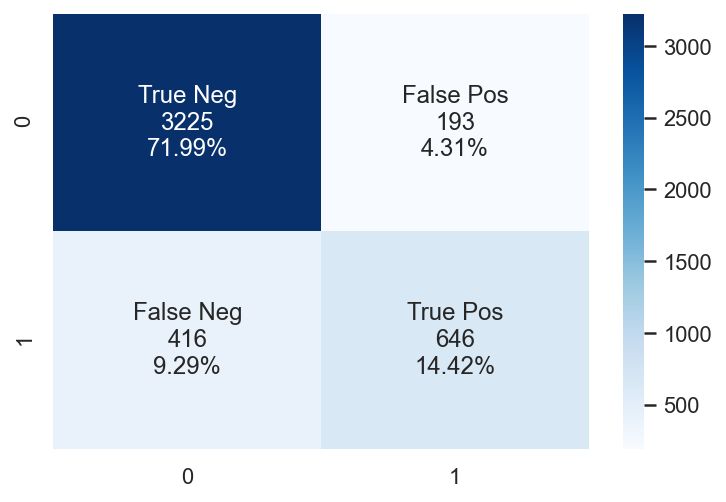

In [31]:
log_model = LogisticRegression(max_iter=1000000)
run_model(log_model,X_train, X_test, y_train, y_test)

## Knn Classifier

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     13671
           1       0.77      0.70      0.73      4249

    accuracy                           0.88     17920
   macro avg       0.84      0.82      0.83     17920
weighted avg       0.88      0.88      0.88     17920

[[12771   900]
 [ 1275  2974]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
------------------------------------------------------------------------------------------------------

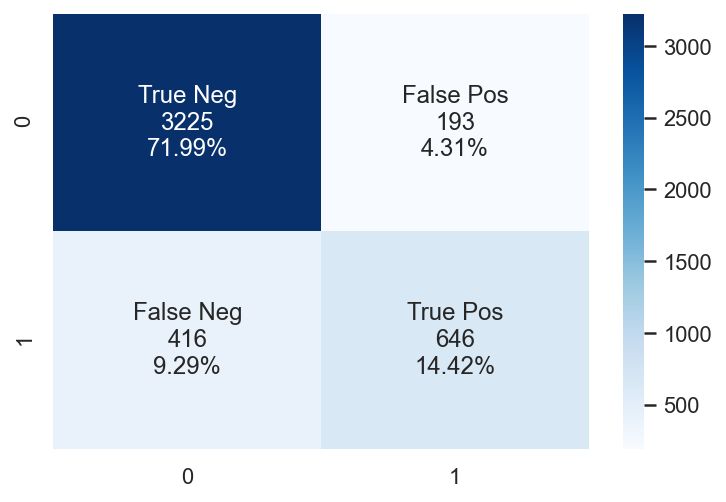

In [32]:
modelKNN = KNeighborsClassifier()
run_model(modelKNN,X_train, X_test, y_train, y_test)

# Resample: Oversample

In [286]:
igual_zero = data_Encoded[data_Encoded['Income'] == 0]
igual_um = data_Encoded[data_Encoded['Income'] == 1]

In [287]:
oversample = resample(igual_um, 
                       replace=True, 
                       n_samples=len(igual_zero), #set the number of samples to equal the number of the majority class
                       random_state=42)

In [288]:
oversample_data = pd.concat([oversample, igual_zero])

In [289]:
X = oversample_data.drop('Income', axis = 1)
y = oversample_data['Income']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=5, stratify=y)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.83      0.89     13671
           1       0.85      0.96      0.90     13671

    accuracy                           0.90     27342
   macro avg       0.90      0.90      0.89     27342
weighted avg       0.90      0.90      0.89     27342

[[11362  2309]
 [  560 13111]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
------------------------------------------------------------------------------------------------------

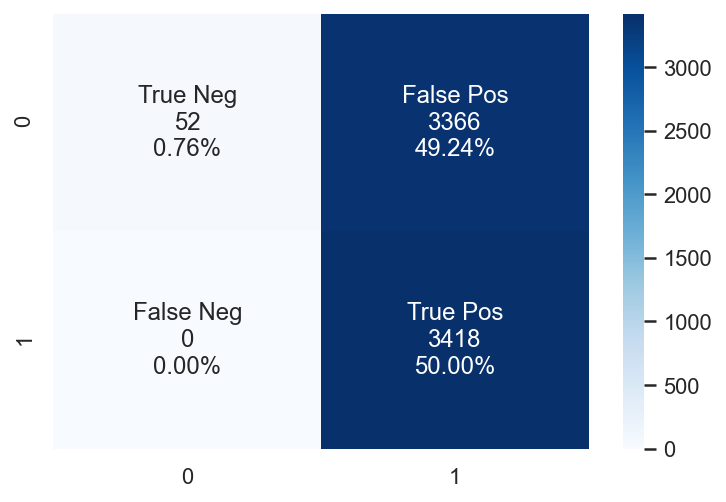

In [290]:
run_model(modelKNN,X_train, X_test, y_train, y_test)

# Test

In [33]:
data_test = pd.read_excel('Test.xlsx')

In [34]:
#Strip and lower
data_test = strip_lower(data_test) 
#Missing Values
data_test = fill_missing_values(data_test,ColumnswithMissingValues)
#Feature Engineering
data_test['Age'] = data_test['Birthday'].apply(ComputeAgeAt2048)
data_test.drop('Birthday', axis=1, inplace=True)
data_test['Group'] = (data_test['Money Received'] - data_test['Ticket Price']).apply(ClassifyCitizen)
data_test['Education_Class'] = data_test['Education Level'].map(EducationClassification)
data_test.drop('Education Level', axis=1, inplace=True)
#One Hot Encode
data_encoded_test = encode_data(data_test, NominalVariables)
data_encoded_test = data_encoded_test.drop(['Name'], axis =1)
data_encoded_test.set_index(["CITIZEN_ID"],inplace=True)

In [35]:
def Diff(li1, li2):
    return (list(list(set(li1)-set(li2)) + list(set(li2)-set(li1))))
missing_columns = Diff(list(X_train.columns),list(data_encoded_test.columns))

In [383]:
data_encoded_test[missing_columns] = 0

In [384]:
labels = modelKNN.predict(data_encoded_test)

In [385]:
data_encoded_test['Income']  = labels

In [386]:
data_encoded_test[['Income']].to_csv("felipe_second_test.csv")